This project was done to explore image classification via convolutional neural networks and image augmentation. The citrus_leaves dataset was used to train a convolutional neural network to classify images of citrus leaves into four categories. The TensorFlow framework was used to build the model. TensorFlow's GitHub code example for CNNs was used as a reference, which can be seen [here](https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb)

In [78]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

The dataset was loaded from TensorFlow's built-in datasets. Note that the citrus_leaves dataset only has a train set available, so the train set was recognized as a whole dataset, of which was split into train and test sets.

In [79]:
# Load the dataset from TensorFlow
dataset, metadata = tfds.load('citrus_leaves', as_supervised=True, with_info=True)
dataset = dataset['train']

In [80]:
# Retrieve the class names
labels = metadata.features['label'].names
labels

['Black spot', 'canker', 'greening', 'healthy']

A normalization function was created to prepare the input values for the neural network. RGB images have pixel values in the range of [0, 255], and these large numbers can cause exploding/vanishing gradients in neural networks, hindering the training process. To avoid this, the pixel values are normalized to the range of [0, 1].

In [81]:
# Method to transform pixel values to the range [0, 1] for better training
def normalize_images(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

In [82]:
# Apply the normalization to the entire dataset
dataset = dataset.map(normalize_images)

In [83]:
# Split dataset into 80% train and 20% test
train_set, test_set = tf.keras.utils.split_dataset(dataset, left_size=0.8)

In [84]:
# Store the sizes of each dataset for number of epoch steps during training
num_train_set = len(train_set)
num_test_set = len(test_set)
print('Number of training samples: ', num_train_set)
print('Number of testing samples: ', num_test_set)

Number of training samples:  475
Number of testing samples:  119


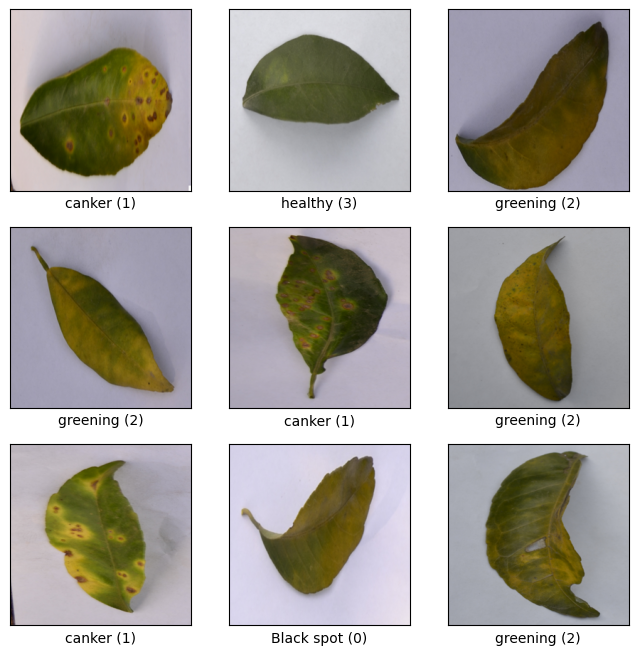

In [85]:
# Visualize a few of the images from the train set along with their labels
plt.figure(figsize=(8,8))
for i, (image, label) in enumerate(train_set.take(9)):
  image = image.numpy()
  plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.xlabel(''.join([labels[label], ' (', str(label.numpy()), ')']))
  plt.xticks([])
  plt.yticks([])
plt.show()

The model built is a standard convolutional neural network model, with two convolution layers, each followed by a max pooling layer. Given each image in the dataset is of the same dimensions (236 x 236 x 3), no resizing was required. The image matrix is then flattened before passing through two fully-connected layers to output a softmax probability for each class. ReLU was used as the activation function for the convolutional and inner dense layers due to its resistance towards gradient issues and efficiency.

In [86]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu,
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

The Adam optimizer was chosen along with a loss function suitable towards multi-classification problems.

In [87]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Prior to training, the train set is cached for better performance during training. The train set is also repeated infinitely and shuffled so that each batch passed through the model holds a different set of images, preventing the model from learning any order in the dataset.

In [88]:
# Train the model
BATCH_SIZE = 32
train_set = train_set.cache().repeat().shuffle(num_train_set).batch(BATCH_SIZE)
history = model.fit(train_set, epochs=10, steps_per_epoch=np.ceil(num_train_set/BATCH_SIZE))

Epoch 1/10
15/15 [==============================] - 59s 4s/step - loss: 5.3287 - accuracy: 0.2896
Epoch 2/10
15/15 [==============================] - 57s 4s/step - loss: 1.1874 - accuracy: 0.3896
Epoch 3/10
15/15 [==============================] - 59s 4s/step - loss: 1.0305 - accuracy: 0.5000
Epoch 4/10
15/15 [==============================] - 58s 4s/step - loss: 0.8800 - accuracy: 0.6396
Epoch 5/10
15/15 [==============================] - 58s 4s/step - loss: 0.8912 - accuracy: 0.6313
Epoch 6/10
15/15 [==============================] - 60s 4s/step - loss: 0.8019 - accuracy: 0.6625
Epoch 7/10
15/15 [==============================] - 58s 4s/step - loss: 0.7030 - accuracy: 0.7417
Epoch 8/10
15/15 [==============================] - 57s 4s/step - loss: 0.4605 - accuracy: 0.8313
Epoch 9/10
15/15 [==============================] - 58s 4s/step - loss: 0.3283 - accuracy: 0.8854
Epoch 10/10
15/15 [==============================] - 57s 4s/step - loss: 0.3549 - accuracy: 0.8792


In [89]:
# Evaluate the model
test_set = test_set.cache().repeat().shuffle(num_test_set).batch(BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_set, steps=np.ceil(num_test_set/BATCH_SIZE), verbose=False)
print('Accuracy on test dataset:', test_accuracy)

Accuracy on test dataset: 0.7265625


The training accuracy was around 88%, which shows the model learned the optimal parameters for the dataset, but we can see the testing accuracy is much lower, at 73%, indicating that some overfitting occurred during training. Below, we make some predictions to visualize the model's capabilities.

In [90]:
# Make some predictions
for test_images, test_labels in test_set.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images, verbose=False)

In [91]:
# Function to plot predicted images and their true labels
def plot_image(i, pred_arr, test_labels, images):
  pred_arr, true_label, img = pred_arr[i], test_labels[i], images[i]
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  predicted_label = np.argmax(pred_arr)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("Pred: {} ({:2.0f}%)\nActual: {}".format(labels[predicted_label],
                                100*np.max(pred_arr),
                                labels[true_label]),
                                color=color)

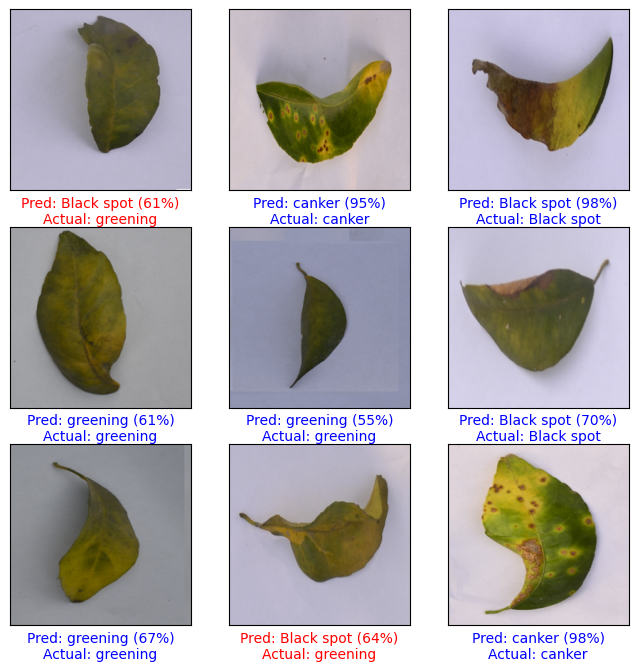

In [92]:
# Visualize predictions
plt.figure(figsize=(8, 8))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plot_image(i, predictions, test_labels, test_images)
plt.show()

Given that the dataset does not have many samples, data augmentation was added as a preprocessing layer to randomly transform images so as to improve the model's training. Random horizontal and vertical flips were added to determine if image transformation could improve training and mitigate overfitting.

In [93]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
])

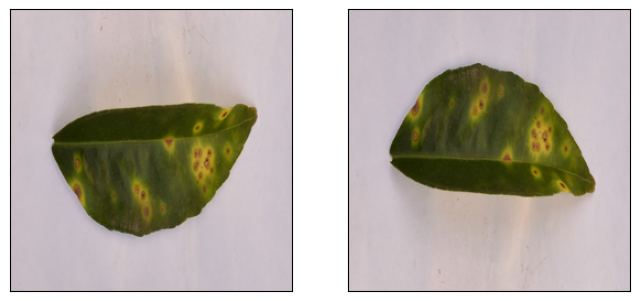

In [94]:
# Visualize the augmentation of an image from the train set
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
  for i in range(2):
    aug_image = data_augmentation(images[0])
    ax = plt.subplot(1, 2, i+1)
    plt.imshow(aug_image)
    plt.xticks([])
    plt.yticks([])

The same model was built, with the addition of the image augmentation layer. The same steps were followed as above for this model.

In [95]:
# Build the model, with the added augmentation layer
model_with_aug = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu,
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

In [96]:
# Compile the model
model_with_aug.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['accuracy'])

In [97]:
# Train the model
history_with_aug = model_with_aug.fit(train_set, epochs=10, steps_per_epoch=np.ceil(num_train_set/BATCH_SIZE))

Epoch 1/10
15/15 [==============================] - 61s 4s/step - loss: 8.9435 - accuracy: 0.2854
Epoch 2/10
15/15 [==============================] - 57s 4s/step - loss: 1.1865 - accuracy: 0.3667
Epoch 3/10
15/15 [==============================] - 57s 4s/step - loss: 1.0983 - accuracy: 0.4583
Epoch 4/10
15/15 [==============================] - 59s 4s/step - loss: 0.9882 - accuracy: 0.5396
Epoch 5/10
15/15 [==============================] - 57s 4s/step - loss: 0.9406 - accuracy: 0.6167
Epoch 6/10
15/15 [==============================] - 57s 4s/step - loss: 0.9150 - accuracy: 0.5896
Epoch 7/10
15/15 [==============================] - 58s 4s/step - loss: 0.8177 - accuracy: 0.6542
Epoch 8/10
15/15 [==============================] - 57s 4s/step - loss: 0.7219 - accuracy: 0.6979
Epoch 9/10
15/15 [==============================] - 58s 4s/step - loss: 0.6376 - accuracy: 0.7188
Epoch 10/10
15/15 [==============================] - 59s 4s/step - loss: 0.6135 - accuracy: 0.7312


In [98]:
# Evaluate the model
test_loss_with_aug, test_accuracy_with_aug = model_with_aug.evaluate(test_set, steps=np.ceil(num_test_set/BATCH_SIZE), verbose=False)
print('Accuracy on test dataset:', test_accuracy_with_aug)

Accuracy on test dataset: 0.703125


As seen above, the training accuracy for the model trained on images with added augmentation is lower than the original model, at 73% compared to the previous model's 88%. However, this model seems to not suffer from the overfitting issues present in the original model, with the testing accuracy very similar to the training accuracy, at around 70%. So even though the model did not achieve high accuracy during training, this model had more success in terms of finding an optimal fit. It seems that with the addition of image augmentation, the model was able to avoid overfitting and reach a reasonable fit.

In [99]:
# Make predictions
for test_images_with_aug, test_labels_with_aug in test_set.take(1):
  test_images_with_aug = test_images_with_aug.numpy()
  test_labels_with_aug = test_labels_with_aug.numpy()
  predictions_with_aug = model_with_aug.predict(test_images_with_aug, verbose=False)

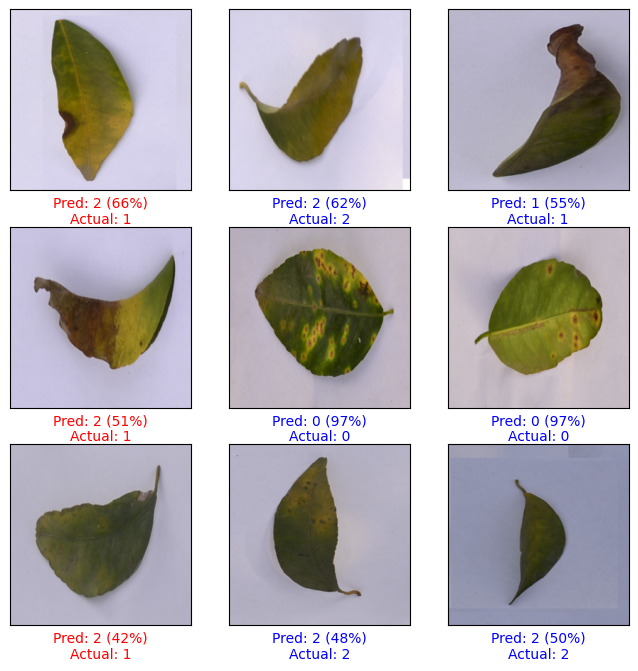

In [100]:
# Visualize predictions
plt.figure(figsize=(8, 8))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plot_image(i, predictions_with_aug, test_labels_with_aug, test_images_with_aug)
plt.show()